In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pynbody
os.environ['TANGOS_DB_CONNECTION'] = '/home/bk639/data_base/Merians_test.db'
os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/bk639/data/MerianCDM'
import merger_properties
#this locks the database, so kill the kernel to unlock
import tangos
#once  tangos is loaded force a reload
import importlib
importlib.reload(tangos)
importlib.reload(merger_properties)
from merger_properties import SmoothAxisRatio
#print names of SmoothAxisRatio functions

tangos.all_simulations()
r615 = tangos.get_simulation('r615.romulus25.3072g1HsbBH')
r761 = tangos.get_simulation('r761.romulus25.3072g1HsbBH')
r613 = tangos.get_simulation('r613.romulus25.3072g1HsbBH')
r918 = tangos.get_simulation('r918.romulus25.3072g1HsbBH')
r431 = tangos.get_simulation('r431.romulus25.3072g1HsbBH')




In [41]:
from tangos.relation_finding import MultiHopMostRecentMergerStrategy
import tangos
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import time




class HaloNode:
    def __init__(self, halo):
        self.halo = halo
        #self.child = None
        self.progenitors = []
        self.ndm = halo.NDM
        self.mvir = halo['Mvir']
        self.merger_time = None
        self.merger_ratio = None

        self.is_merger = False
        self.merger_ratio = None

        try:
            self.ba_s = halo.calculate('ba_s_at_reff()')
            self.ca_s = halo.calculate('ca_s_at_reff()')
            self.ba_d = halo.calculate('ba_d_at_reff()')
            self.ca_d = halo.calculate('ca_d_at_reff()')
        except:
            self.ba_s = self.ca_s = self.ba_d = self.ca_d = None

    def calculate_merger_ratio(self):
        if len(self.progenitors) > 1:
            self.is_merger = True
            main_progenitor_mass = max(p.mvir for p in self.progenitors)
            sum_other_masses = sum(p.mvir for p in self.progenitors if p.mvir != main_progenitor_mass)
            if sum_other_masses > 0:
                self.merger_ratio = main_progenitor_mass / sum_other_masses
            else:
                self.merger_ratio = None  # or some other value to indicate division by zero
                self.is_merger = False
        else:
            self.is_merger = False
            self.merger_ratio = None


def build_merger_tree(input_halo, max_depth=10, min_fractional_weight=0.01, min_fractional_NDM=0.01, timeout=300):
    """
    Build a merger tree starting from the input halo.
    :param input_halo: Halo to build the tree from
    :param max_depth: Maximum number of generations to go back
    :param min_fractional_weight: Minimum fractional weight to consider a progenitor
    :param min_fractional_NDM: Minimum fractional NDM to consider a progenitor
    :param timeout: Maximum time (in seconds) to spend building the tree
    :return: Dictionary representing the merger tree
    """
    start_time = time.time()
    tree = defaultdict(list)
    start_node = HaloNode(input_halo)
    tree[0].append(start_node)

    # Use MultiHopAllProgenitorsStrategy to get all progenitors
    strategy = tangos.relation_finding.MultiHopAllProgenitorsStrategy(input_halo, nhops_max=max_depth)
    link_objs = strategy._get_query_all()

    # Create a cache of links
    link_cache = defaultdict(list)
    for obj in link_objs:
        link_cache[obj.halo_from_id].append(obj)

    def build_subtree(node, depth):
        if depth >= max_depth or time.time() - start_time > timeout:
            return

        link_objs = link_cache.get(node.halo.id, [])
        max_NDM = max((o.halo_to.NDM for o in link_objs), default=0)

        for obj in link_objs:
            progenitor = obj.halo_to
            max_weight = max(o.weight for o in link_objs if o.halo_from_id == obj.halo_from_id)

            if (obj.weight > max_weight * min_fractional_weight and
                progenitor.NDM > min_fractional_NDM * max_NDM):

                progenitor_node = HaloNode(progenitor)
                progenitor_node.weight = obj.weight
                #before adding progenitor halo to the list of progenitors, check if it is already in the list
                #check progenitor_node.halo.halo_number against [p.halo.halo_number for p in node.progenitors]
                if progenitor_node.halo.halo_number not in [p.halo.halo_number for p in node.progenitors]:
                    node.progenitors.append(progenitor_node)
                    tree[depth + 1].append(progenitor_node)

                    build_subtree(progenitor_node, depth + 1)

        # After adding all progenitors, calculate the merger ratio
        node.calculate_merger_ratio()
        if node.is_merger:
            node.merger_time = node.halo.timestep.time_gyr

        # Return the main progenitor (the one with the highest mass)
        return max(node.progenitors, key=lambda x: x.mvir) if node.progenitors else None

    main_line = [start_node]
    current_node = start_node
    while current_node:
        current_node = build_subtree(current_node, len(main_line))
        if current_node:
            main_line.append(current_node)

    return tree, main_line


def print_merger_tree(tree):
    for depth, nodes in tree.items():
        print(f"Depth {depth}:")
        for node in nodes:
            print(f"  Halo {node.halo.halo_number} at time {node.halo.timestep.time_gyr:.2f} Gyr")
            print(f"    Mvir: {node.mvir:.2e} Msun, NDM: {node.ndm}")
            if node.ba_s is not None:
                print(f"    Shape (s): ba={node.ba_s:.2f}, ca={node.ca_s:.2f}")
                print(f"    Shape (d): ba={node.ba_d:.2f}, ca={node.ca_d:.2f}")
            if node.progenitors:
                # print("    Progenitors:", [prog.halo.halo_number for prog in node.progenitors])
                print("    Progenitors:", [prog.halo for prog in node.progenitors])
            if node.is_merger:
                print(f"    Merger at {node.merger_time} Gyr with ratio {node.merger_ratio}")
        print()



def visualize_tree(tree):
    G = nx.DiGraph()
    time_to_nodes = defaultdict(list)

    # Create nodes and organize by time
    for depth, nodes in tree.items():
        for node in nodes:
            time = round(node.halo.timestep.time_gyr, 2)  # Round to 2 decimal places
            G.add_node(node.halo.id, time=time, mvir=node.mvir)
            time_to_nodes[time].append(node.halo.id)
            for prog in node.progenitors:
                G.add_edge(prog.halo.id, node.halo.id)

    # Calculate positions
    pos = {}
    times = sorted(time_to_nodes.keys(), reverse=True)
    for i, time in enumerate(times):
        nodes = time_to_nodes[time]
        y = 1 - (i / (len(times) - 1))  # Normalize y position
        for j, node in enumerate(nodes):
            x = (j + 1) / (len(nodes) + 1)  # Distribute nodes horizontally
            pos[node] = (x, y)

    plt.figure(figsize=(5, 12))

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=True, edge_color='gray', arrowsize=20)

    # Draw nodes
    node_sizes = [300 * (G.nodes[node]['mvir'] / max(nx.get_node_attributes(G, 'mvir').values())) ** 0.5 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes)

    # Draw labels
    nx.draw_networkx_labels(G, pos, {node: f"{node}\n{G.nodes[node]['time']:.2f} Gyr" for node in G.nodes}, font_size=8)

    # Add time labels on the y-axis
    plt.yticks([(1 - (i / (len(times) - 1))) for i in range(len(times))], [f"{time:.2f} Gyr" for time in times])

    plt.title("Time-Organized Merger Tree Visualization")
    plt.xlabel("Halo ID")
    plt.ylabel("Time")
    plt.tight_layout()
    plt.show()


In [103]:
import matplotlib.pyplot as plt
import numpy as np
def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )

def plot_ba_ca(main_line,figure_folder,sim_name):

    times = [node.halo.timestep.time_gyr for node in main_line]
    ba_s = [node.ba_s for node in main_line]
    ca_s = [node.ca_s for node in main_line]
    ba_d = [node.ba_d for node in main_line]
    ca_d = [node.ca_d for node in main_line]

    fig = plt.figure(figsize=(10, 8))
    ms = 10
    scatter_s = plt.scatter(ba_s, ca_s, c=times, cmap='viridis', marker= '*', label='Stellar')
    scatter_d = plt.scatter(ba_d, ca_d, c=times, cmap='viridis', marker='o', label='Dark Matter')
    plt.colorbar(scatter_s, label='Time (Gyr)')

    # Connect points with lines
    plt.plot(ba_s, ca_s, '-', color='blue', alpha=0.5)
    plt.plot(ba_d, ca_d, '-', color='red', alpha=0.5)

    # Mark merger events
    for node in main_line:
        if node.is_merger:
            plt.plot(node.ba_s, node.ca_s, '*', markersize=ms, mfc='none', mec='black')
            plt.plot(node.ba_d, node.ca_d, 'o', markersize=ms, mfc='none', mec='black')

    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    plt.xlabel('B/A')
    plt.ylabel('C/A')
    plt.title(sim_name)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    fig.savefig(figure_folder + 'QvS_mergers.png')
    plt.close()


    fig,ax = plt.subplots(3,1,figsize=(10, 12), sharex=True)
    ax[0].plot(times, ba_s, label='Stellar', color='blue',ls='--',marker='o')
    ax[0].plot(times, ba_d, label='Dark Matter', color='k',ls='--',marker='o')
    ax[0].set_ylabel('B/A')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    ax[0].set_ylim(0, 1)

    ax[1].plot(times, ca_s, label='Stellar', color='green',ls='--',marker='o')
    ax[1].plot(times, ca_d, label='Dark Matter', color='k',ls='--',marker='o')
    ax[1].set_ylabel('C/A')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    ax[1].set_ylim(0, 1)

    #add vertical lines for merger events label with merger ratio

    for node in main_line:
        if node.is_merger:
            ax[0].axvline(node.merger_time, color='red', linestyle='--')
            ax[1].axvline(node.merger_time, color='red', linestyle='--')
            ax[0].text(node.merger_time+.02, 0.1, f'{node.merger_ratio:.1f}', rotation=90, verticalalignment='center', fontsize=12)
            ax[1].text(node.merger_time+.02, 0.9, f'{node.merger_ratio:.1f}', rotation=90, verticalalignment='center', fontsize=12)




    #triaxiality plot vs time for stellar and dark matter components

    #fig,ax = plt.subplots(1,1,figsize=(10, 4), sharex=True)

    ba_s = np.array(ba_s)
    ca_s = np.array(ca_s)
    ba_d = np.array(ba_d)
    ca_d = np.array(ca_d)

    T_s = T(ba_s,ca_s)
    T_d = T(ba_d,ca_d)
    ax = ax[2]
    ax.plot(times, T_s, label='Stellar', color='blue',ls='--',marker='o')
    ax.plot(times, T_d, label='Dark Matter', color='k',ls='--',marker='o')
    #mark merger events
    for node in main_line:
        if node.is_merger:
            ax.axvline(node.merger_time, color='red', linestyle='--')
            ax.text(node.merger_time+ .02, 0.1, f'{node.merger_ratio:.1f}', rotation=90, verticalalignment='center', fontsize=12)



    text_x_position = np.min(times) - .07
    ax.plot([4, 14], [1 / 3, 1 / 3], c='.75', linestyle='--', zorder=0)
    ax.plot([4, 14], [2 / 3, 2 / 3], c='.75', linestyle='--', zorder=0)
    ax.tick_params(which='both', labelsize=15)
    ax.text(text_x_position, 1 / 6, 'Oblate', fontsize=12, rotation='vertical', verticalalignment='center', c='k')
    ax.text(text_x_position, 3 / 6, 'Triaxial', fontsize=12, rotation='vertical', verticalalignment='center', c='k')
    ax.text(text_x_position, 5 / 6, 'Prolate', fontsize=12, rotation='vertical', verticalalignment='center', c='k')
    ax.set_xlim(np.min(times)-.1,np.max(times))
    ax.set_ylim(0, 1)
    ax.legend()
    ax.set_ylabel('T', fontsize=20)

    #convert times to redshift for x-tick labels
    redshifts = [node.halo.timestep.redshift for node in main_line]

    ax.set_xticks(times)
    #for the labels display as floats with 2 decimal places
    redshifts = [f'{redshift:.2f}' for redshift in redshifts]

    ax.set_xticklabels(redshifts)
    ax.set_xlabel('Redshift', fontsize=20)

    fig.suptitle(sim_name, fontsize=20)

    fig.savefig(figure_folder + 'TvsTime_mergers.png')
    plt.show(fig)
    print(times,T_s)



In [104]:

def plot_ba_ca_smoothed(main_line,figure_folder,sim_name):

    times = [node.halo.timestep.redshift for node in main_line]
    #get halos
    halos = [node.halo for node in main_line]
    ba_s = [halo['ba_s'] for halo in halos]
    ca_s = [halo['ca_s'] for halo in halos]
    ba_d = [halo['ba_d'] for halo in halos]
    ca_d = [halo['ca_d'] for halo in halos]
    ba_s_smoothed = [halo.calculate('ba_s_smoothed()') for halo in halos]
    ca_s_smoothed = [halo.calculate('ca_s_smoothed()') for halo in halos]
    ba_d_smoothed = [halo.calculate('ba_d_smoothed()') for halo in halos]
    ca_d_smoothed = [halo.calculate('ca_d_smoothed()') for halo in halos]
    reff = [halo['reff'] for halo in halos]
    rbins = [halo['rbins'] for halo in halos]


    #get number of halos
    n = len(halos)
    #create a plot with n rows and 2 columns
    #plot rbins vs ba_s and ba_s_smoothed, and ca_s and ca_s_smoothed
    #set height based on n
    height = 2 * n
    fig, axs = plt.subplots(n, 2, figsize=(15, height), sharex='col', sharey='row')
    axs = axs.T
    rmax = np.max(rbins[-1]) + 4



    for i in range(n):
        ax = axs[:, i]
        #mark merger events
        if main_line[i].is_merger:
            #add background color to plot to highlight merger events
            ax[0].set_facecolor('lightgray')
            ax[1].set_facecolor('lightgray')

        ax[0].grid()
        ax[1].grid()
        ax[0].set_title(f'z = {times[i]:.2f}')
        ax[1].set_title(f'z = {times[i]:.2f}')
        ax[0].vlines(reff[i], 0, 1, color='gray')
        ax[0].plot(rbins[i], ba_s[i], label='Stellar B/A', color='r')
        ax[0].plot(rbins[i], ba_s_smoothed[i], color='r', linestyle='--')
        ax[0].plot(rbins[i], ba_d[i], label='Dark B/A', color='k')
        ax[0].plot(rbins[i], ba_d_smoothed[i], label='Smoothed', color='k', linestyle='--')
        ax[0].set_ylim(0, 1)
        ax[1].vlines(reff[i], 0, 1, color='gray')
        ax[1].plot(rbins[i], ca_s[i], label='Stellar C/A', color='b')
        ax[1].plot(rbins[i], ca_s_smoothed[i], color='b', linestyle='--')
        ax[1].plot(rbins[i], ca_d[i], label='Dark C/A', color='k')
        ax[1].plot(rbins[i], ca_d_smoothed[i], label='ca_d_smoothed', color='k', linestyle='--')
        ax[1].set_ylim(0, 1)
        ax[0].set_ylabel('B/A')
        ax[1].set_ylabel('C/A')
        if i == 1:
            ax[0].legend(loc='lower right')
            ax[1].legend(loc='lower right')
        ax[0].set_xlim(0, rmax)
        ax[1].set_xlim(0, rmax)

    ax[0].set_xlabel('r [kpc]')
    ax[1].set_xlabel('r [kpc]')
    fig.suptitle(sim_name)
    plt.show()
    fig.savefig(figure_folder + 'ba_ca_smoothed.png')
    plt.close(fig)




In [105]:

def find_most_recent_merger(main_line):
    for i, node in enumerate(main_line):
        if node.is_merger:
            return i, node
    return None, None

import matplotlib.pyplot as plt
import numpy as np

def plot_merger_ba_ca(main_lines, sims, figure_folder, link_dm_to_stellar=True, link_timesteps=True):
    width = 10
    height = 8
    fig, ax = plt.subplots(figsize=(width, height))
    ba_d_ba_s_ratios = {'Before': [], 'During': [], 'After': []}
    ca_d_ca_s_ratios = {'Before': [], 'During': [], 'After': []}
    T_s_minus_T_d = {'Before': [], 'During': [], 'After': []}

    for idx, (main_line, sim) in enumerate(zip(main_lines, sims)):
        merger_idx, merger_node = find_most_recent_merger(main_line)
        if merger_idx is None:
            print(f"No merger found for simulation {sim}")
            continue

        before = main_line[merger_idx + 1] if merger_idx + 1 < len(main_line) else None
        during = main_line[merger_idx]
        after = main_line[merger_idx - 1] if merger_idx > 0 else None

        for phase, color, label in zip([before, during, after],
                                               ['mediumblue', 'k', 'springgreen'],
                                               ['Before', 'During', 'After']):
            if phase is not None:
                ba_s, ca_s = phase.ba_s, phase.ca_s
                ba_d, ca_d = phase.ba_d, phase.ca_d

                if ba_s is not None and ca_s is not None:
                    ax.scatter(ba_s, ca_s, c=color, marker='*')
                if ba_d is not None and ca_d is not None:
                    ax.scatter(ba_d, ca_d, c=color, marker='o', facecolors='none')
                                # Compute ratios and triaxiality difference
                if ba_s is not None and ca_s is not None and ba_d is not None and ca_d is not None:
                    ba_d_ba_s_ratios[label].append(ba_d / ba_s)
                    ca_d_ca_s_ratios[label].append(ca_d / ca_s)
                    T_s = T(ba_s, ca_s)
                    T_d = T(ba_d, ca_d)
                    T_s_minus_T_d[label].append(T_s - T_d)
                # Link dark matter to stellar components
                if link_dm_to_stellar and ba_s is not None and ca_s is not None and ba_d is not None and ca_d is not None:
                    ax.plot([ba_d, ba_s], [ca_d, ca_s], c=color, alpha=0.5, linestyle='--')

        # Link across timesteps
        if link_timesteps:
            phases = [p for p in [before, during, after] if p is not None]
            for component in ['s', 'd']:
                ba_values = [getattr(p, f'ba_{component}') for p in phases if getattr(p, f'ba_{component}') is not None]
                ca_values = [getattr(p, f'ca_{component}') for p in phases if getattr(p, f'ca_{component}') is not None]
                if len(ba_values) > 1 and len(ca_values) > 1:
                    ax.plot(ba_values, ca_values, c='gray', alpha=0.5, linestyle='-')

    #add dummy points for legend
    ax.scatter([], [], c='k', marker='*', label='Stellar')
    ax.scatter([], [], c='k', marker='o', label='Dark Matter')
    ax.scatter([], [], c='mediumblue', marker='o', label='Before')
    ax.scatter([], [], c='k', marker='o', label='During')
    ax.scatter([], [], c='springgreen', marker='o', label='After')

    ax.set_aspect('equal')
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    ax.set_xlabel('b/a')
    ax.set_ylabel('c/a')
    ax.set_title('Shape Evolution around Merger (All Simulations)')
    ax.legend( loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    #different names for links
    if link_dm_to_stellar and link_timesteps:
        plt.savefig(f'{figure_folder}/merger_ba_ca_all_sims_dm_link_stellarDM_timesteps.png', bbox_inches='tight')
    elif link_dm_to_stellar:
        plt.savefig(f'{figure_folder}/merger_ba_ca_all_sims_link_dm_stellar.png', bbox_inches='tight')
    elif link_timesteps:
        plt.savefig(f'{figure_folder}/merger_ba_ca_all_sims_link_timesteps.png', bbox_inches='tight')
    else:
        plt.savefig(f'{figure_folder}/merger_ba_ca_all_sims.png', bbox_inches='tight')
    #plt.close()

    # Print statistics
    print("\nStatistics for shape parameters around mergers:")
    for label in ['Before', 'During', 'After']:
        print(f"\n{label} merger:")
        for name, data in zip(['ba_d/ba_s', 'ca_d/ca_s', 'T_s - T_d'],
                              [ba_d_ba_s_ratios[label], ca_d_ca_s_ratios[label], T_s_minus_T_d[label]]):
            if data:
                mean = np.mean(data)
                std = np.std(data)
                print(f"  {name}: mean = {mean:.3f}, std = {std:.3f}")
            else:
                print(f"  {name}: No data available")



r615.romulus25.3072g1HsbBH
Building merger tree for <Simulation("r615.romulus25.3072g1HsbBH")>


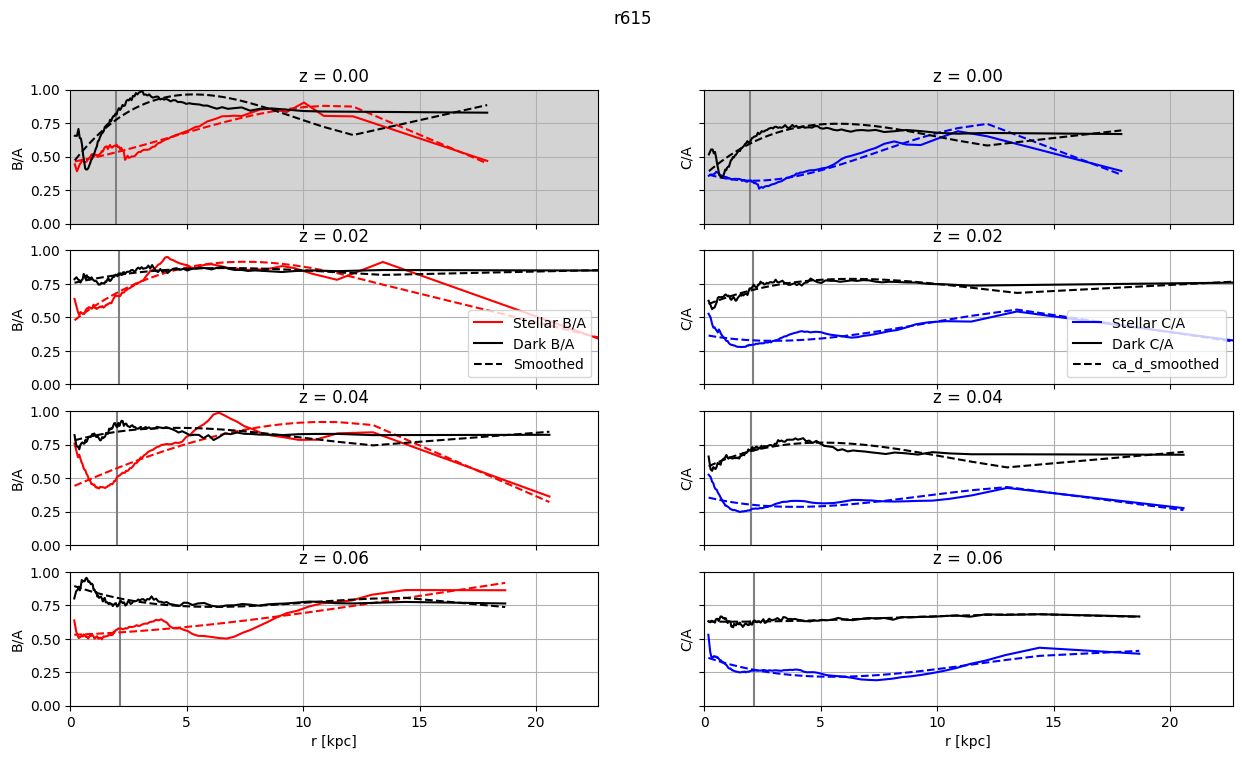

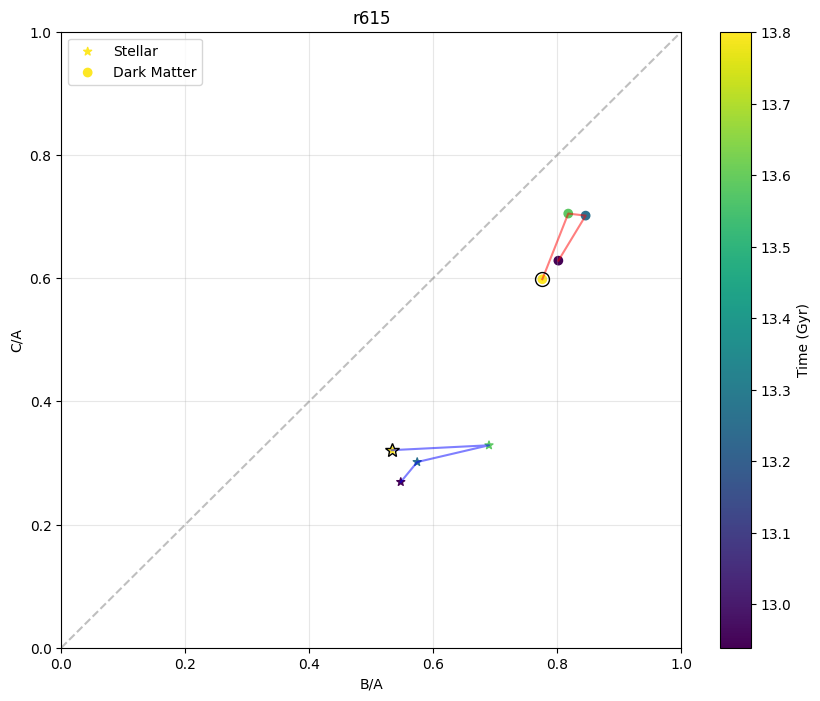

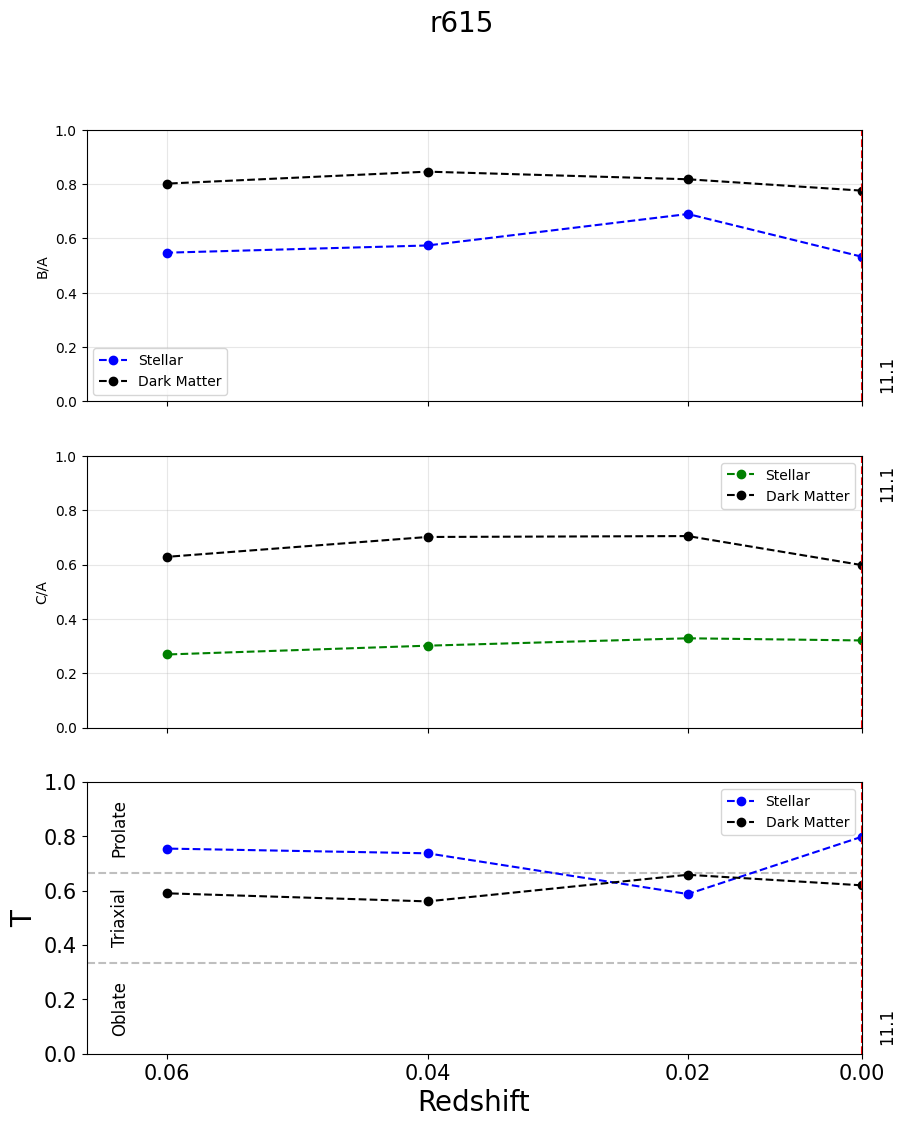

[13.800513767674692, 13.58515128810075, 13.26210756874063, 12.939063849389166] [0.7980067  0.58756163 0.73744054 0.75483212]
r761.romulus25.3072g1HsbBH
Building merger tree for <Simulation("r761.romulus25.3072g1HsbBH")>


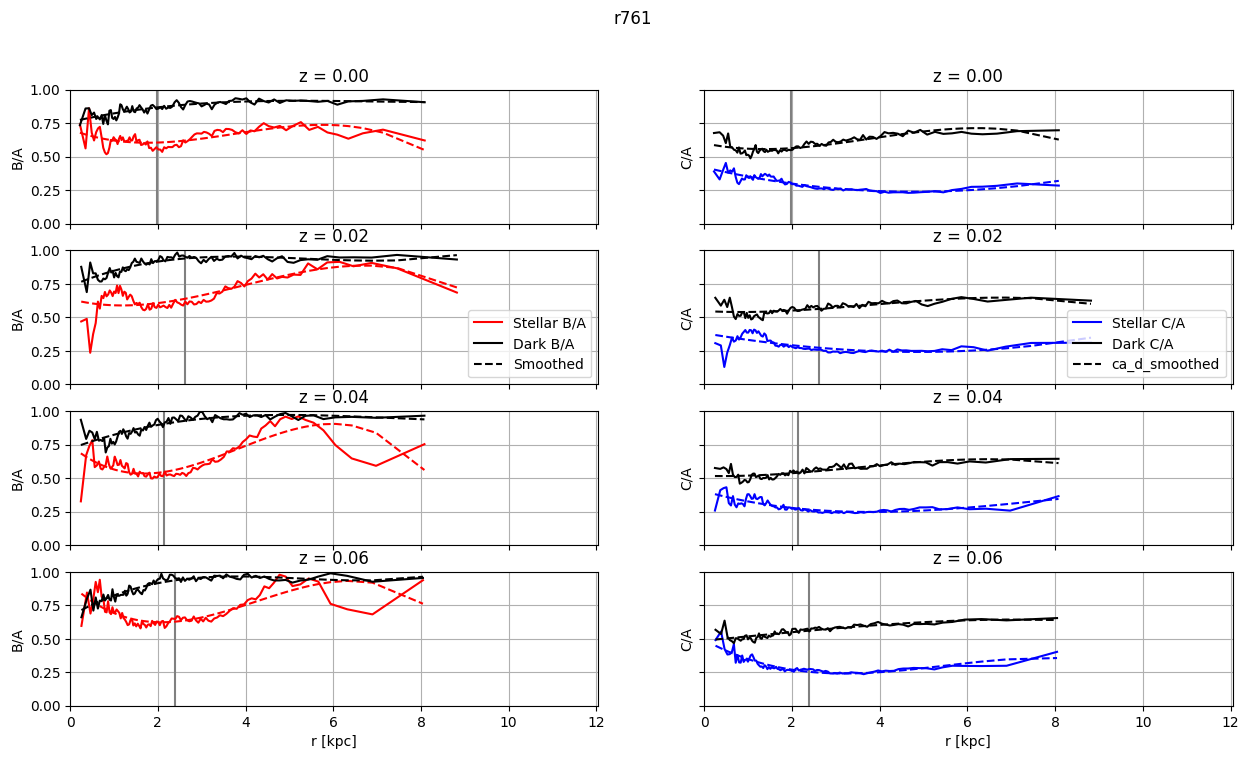

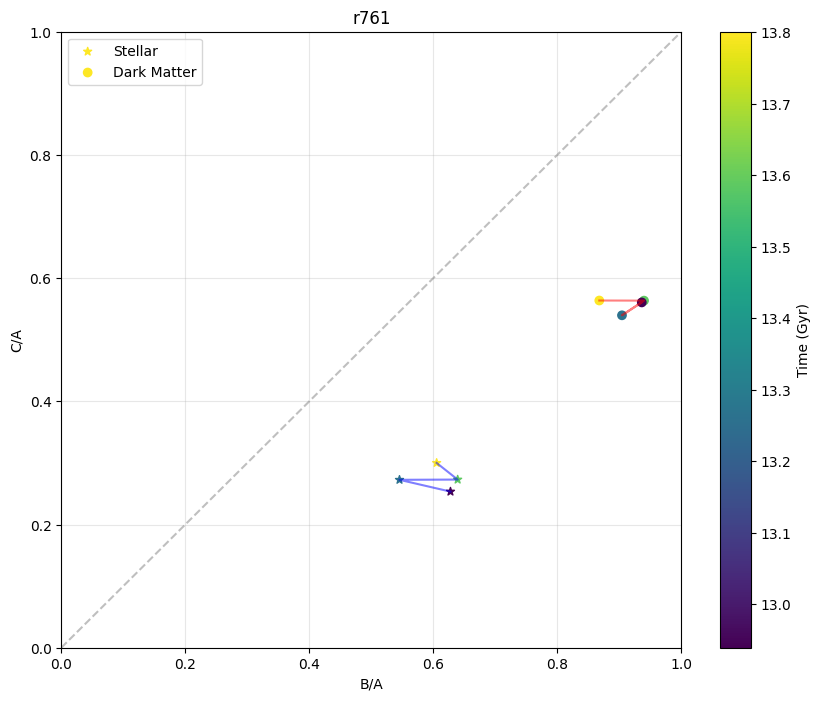

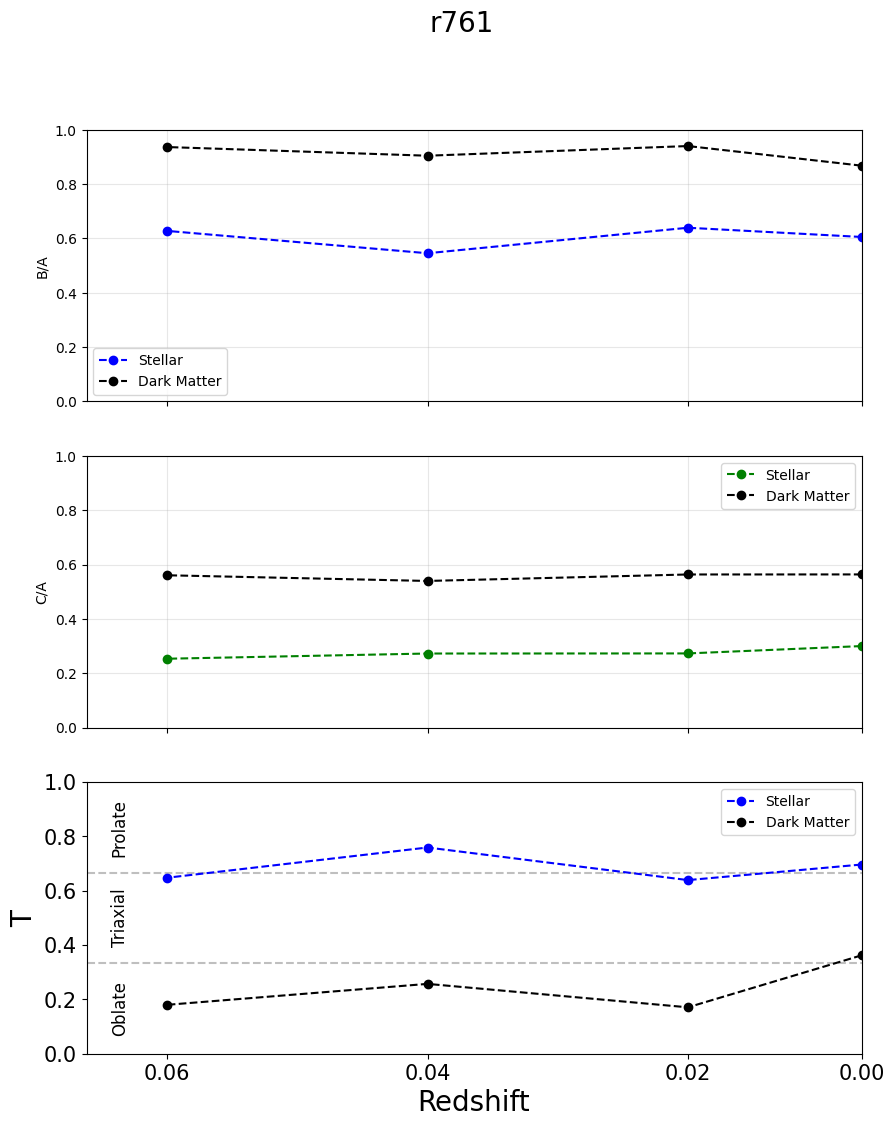

[13.800513768024715, 13.585150868501694, 13.262106519217904, 12.939062169920373] [0.69614372 0.63887557 0.75881638 0.64756767]
r613.romulus25.3072g1HsbBH
Building merger tree for <Simulation("r613.romulus25.3072g1HsbBH")>


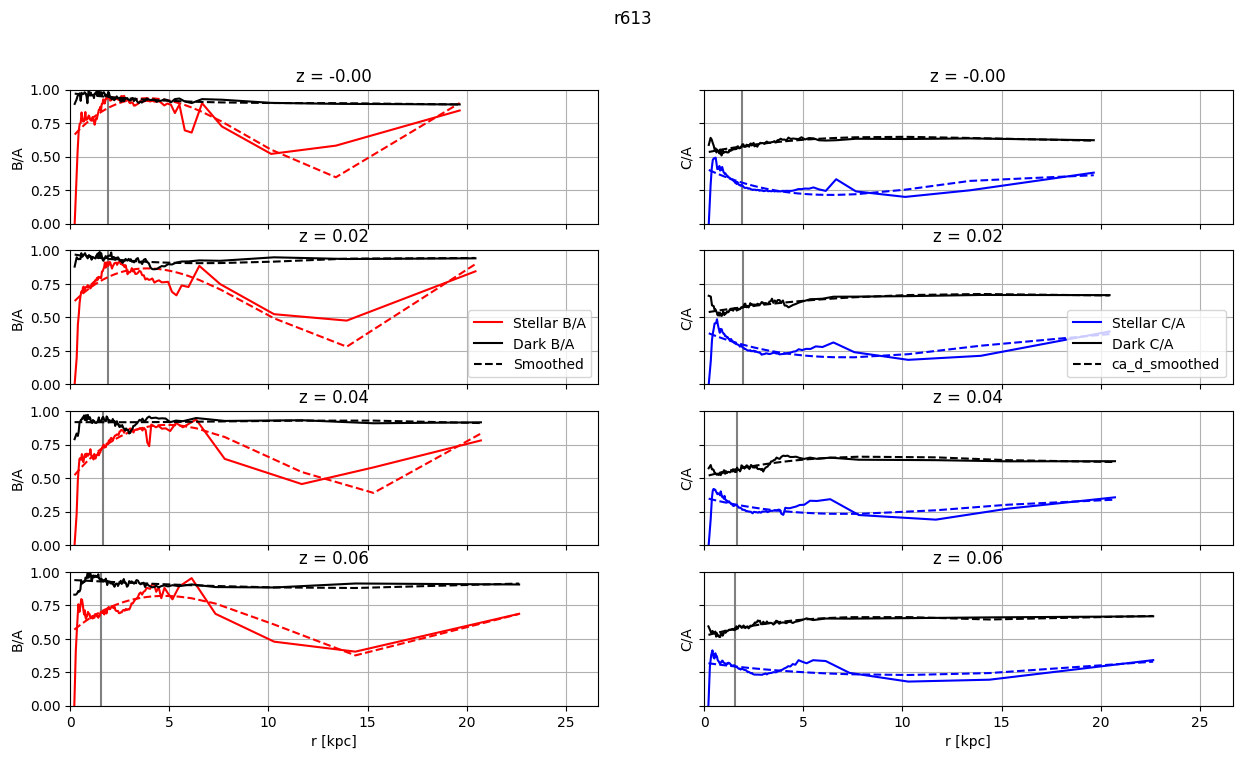

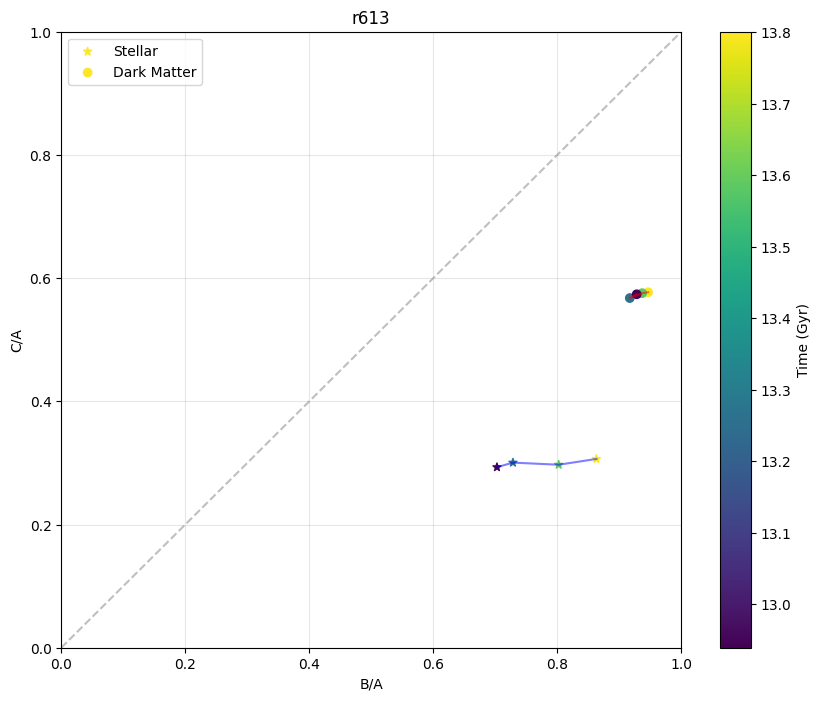

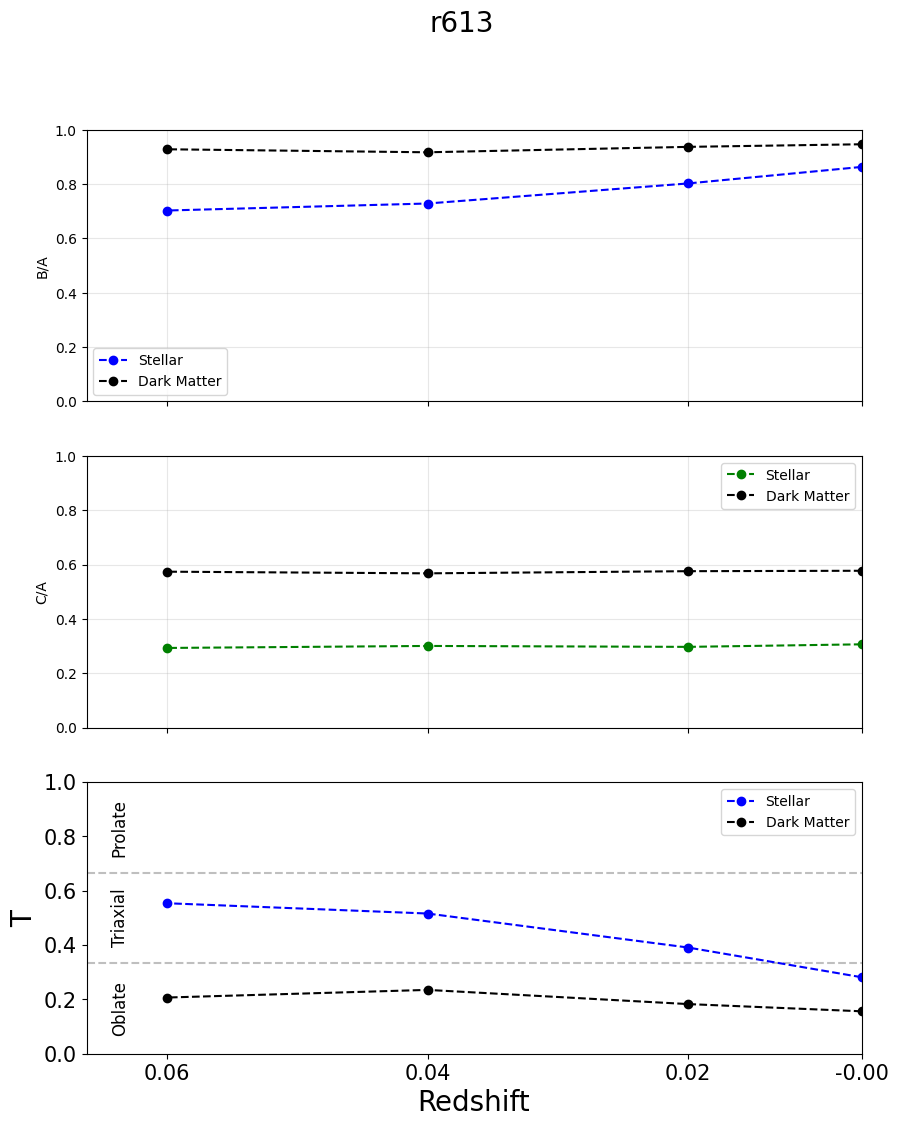

[13.800513768271356, 13.585151288504253, 13.262107568859529, 12.939063849221398] [0.28151961 0.39085331 0.51588296 0.55373629]
r918.romulus25.3072g1HsbBH
Building merger tree for <Simulation("r918.romulus25.3072g1HsbBH")>


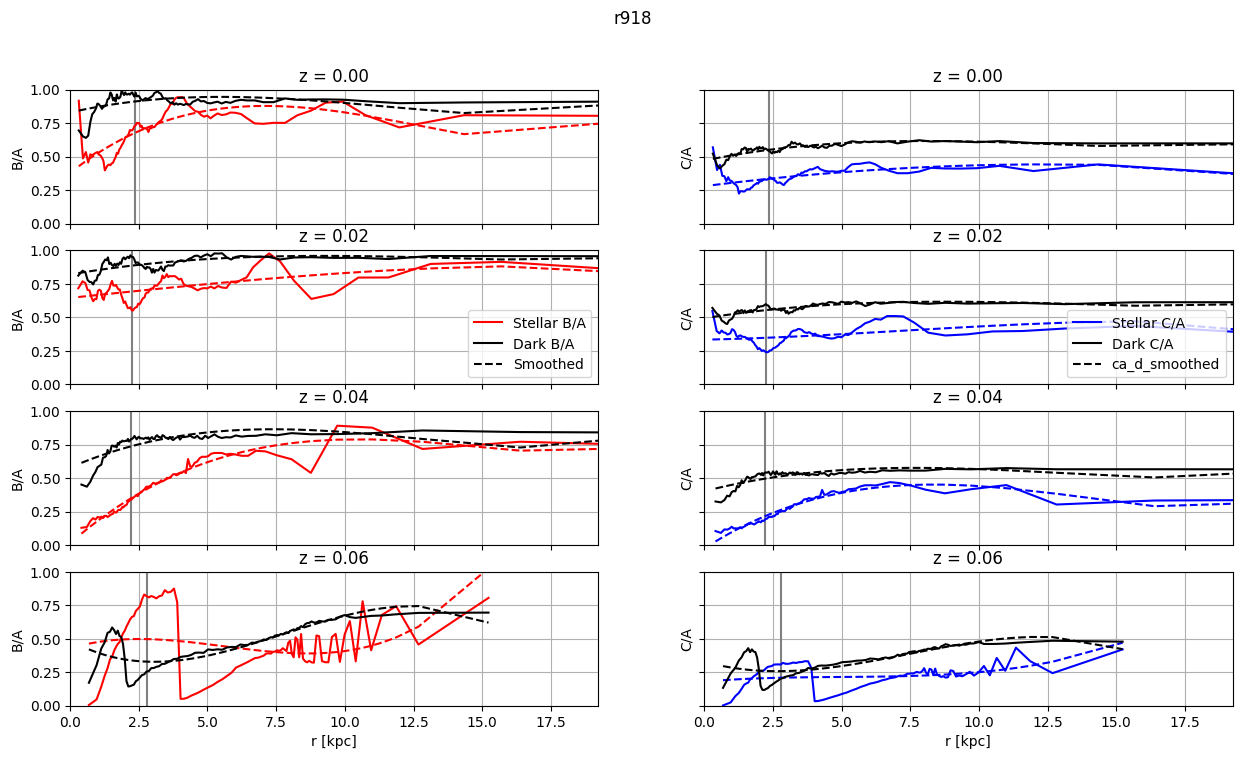

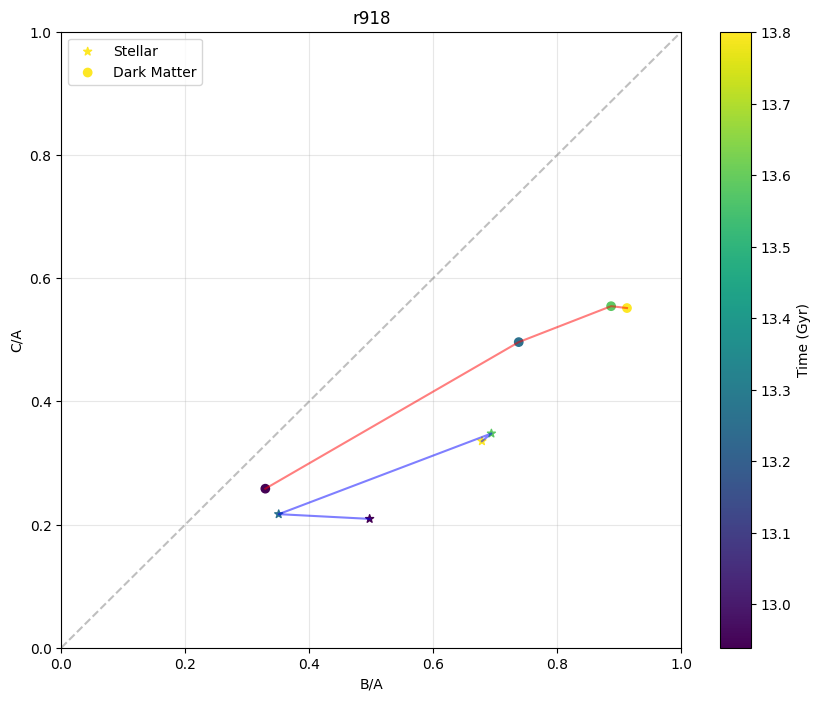

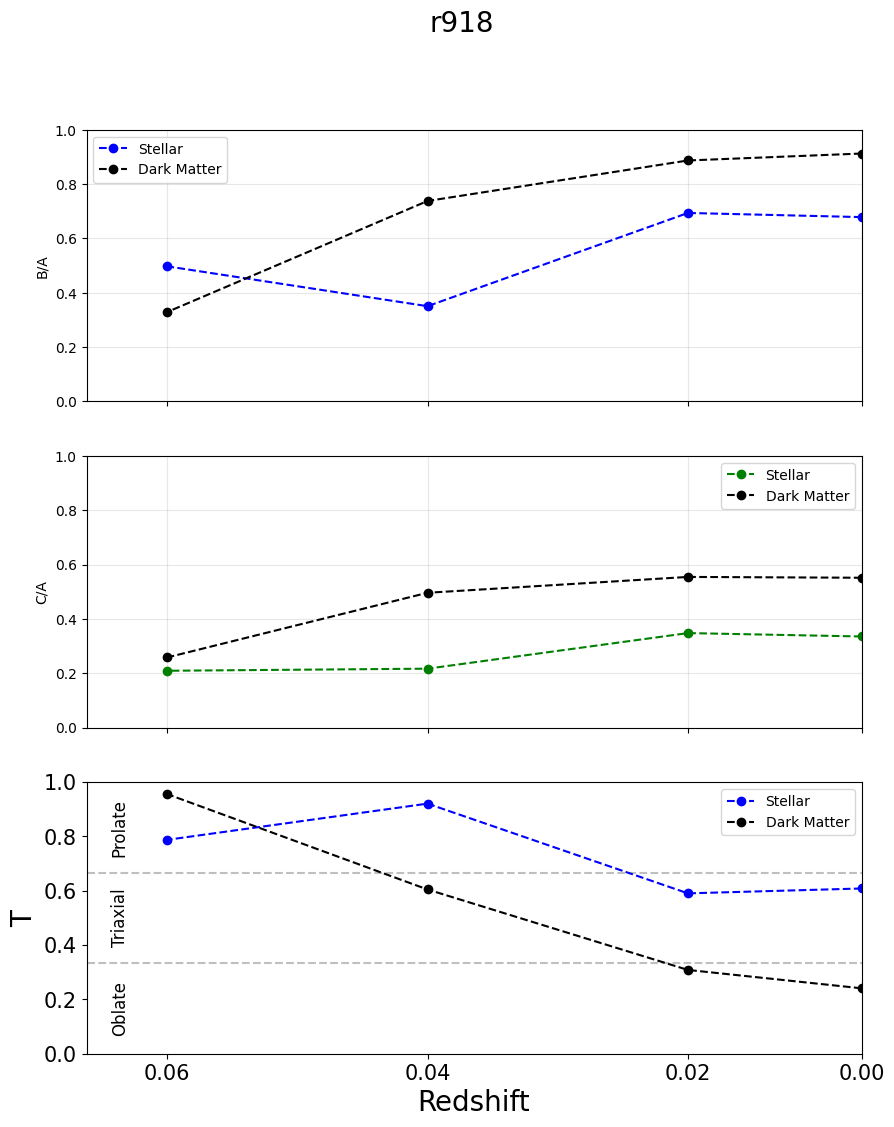

[13.800513767740883, 13.58515128817738, 13.262107568836555, 12.939063849507644] [0.6080082  0.59009465 0.9202942  0.78706461]


In [110]:
sims = [r615, r761, r613, r918]
merger_halos = [1,1,1,1]
#sims = [r918]
trees = []
main_lines = []

for sim in sims:
    #get simulation name from sim object
    sim_name = str(sim.basename)
    print(sim_name)
    #strip everything excpt for something like r615
    sim_name = sim_name.split('.')[0]

    print(f"Building merger tree for {sim}")
    figure_folder = f'../../Figures/mergers/{sim_name}'
    if not os.path.exists(figure_folder):
        os.makedirs(figure_folder)

    halo = sim.timesteps[-1].halos[merger_halos[sims.index(sim)]]
    tree, main_line = build_merger_tree(halo, max_depth=10)
    #print_merger_tree(tree)
    plot_ba_ca_smoothed(main_line, figure_folder, sim_name)
    plot_ba_ca(main_line, figure_folder, sim_name)

    trees.append(tree)
    main_lines.append(main_line)

No merger found for simulation <Simulation("r761.romulus25.3072g1HsbBH")>
No merger found for simulation <Simulation("r613.romulus25.3072g1HsbBH")>
No merger found for simulation <Simulation("r918.romulus25.3072g1HsbBH")>

Statistics for shape parameters around mergers:

Before merger:
  ba_d/ba_s: mean = 1.185, std = 0.000
  ca_d/ca_s: mean = 2.144, std = 0.000
  T_s - T_d: mean = -0.071, std = 0.000

During merger:
  ba_d/ba_s: mean = 1.456, std = 0.000
  ca_d/ca_s: mean = 1.865, std = 0.000
  T_s - T_d: mean = 0.178, std = 0.000

After merger:
  ba_d/ba_s: No data available
  ca_d/ca_s: No data available
  T_s - T_d: No data available


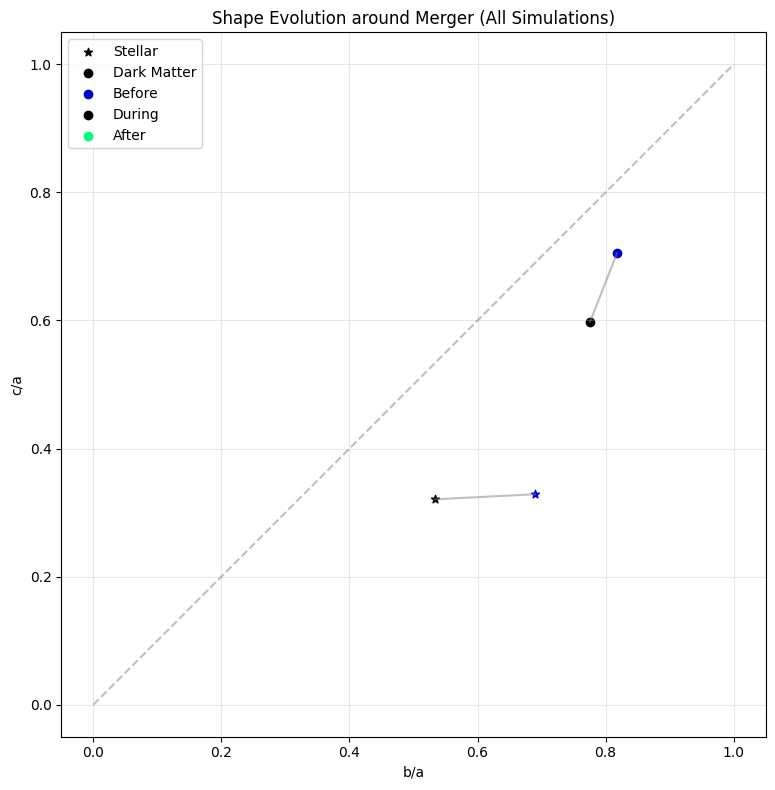

In [111]:

# After collecting all data, create the merger-focused plots
#plot_merger_ba_ca(main_lines, sims, '../../Figures/mergers', link_dm_to_stellar=True, link_timesteps=False)
plot_merger_ba_ca(main_lines, sims, '../../Figures/mergers', link_dm_to_stellar=False, link_timesteps=True)
#plot_merger_ba_ca(main_lines, sims, '../../Figures/mergers', link_dm_to_stellar=True, link_timesteps=True)
